In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 


# Methoden & Technieken

## Restricted Boltzmann Machines

22 Dec 2022

Deze slides zijn gebaseerd op
- Hoofdstuk 10 van *Hands-on unsupervised learning in Python* van Patel
- Hoofdstuk 16 van [deeplearningbook.org](deeplearningbook.org)
- *Salakhutdinov, R., Mnih, A., & Hinton, G. (2007, June). Restricted Boltzmann machines for collaborative filtering. In Proceedings of the 24th international conference on Machine learning (pp. 791-798).*

De code in dit notebook is aangepast uit
[https://github.com/aapatel09/handson-unsupervised-learning/blob/master/10_rbms.ipynb](https://github.com/aapatel09/handson-unsupervised-learning/blob/master/10_rbms.ipynb)

### Inhoud

- Restricted Boltzmann Machines
- Voorbeeld: Movie Recommender Systems
  - Het model
  - Contrastive Divergence
  - De Monte Carlo benadering
  - De Markov Chain Monte Carlo benadering

### Restrictive Boltzmann Machines

Eerder definieerden we een Boltzmann Machine als een *undirected graphical model* met *visible* (invoer) en *latent* (hidden) nodes. We merkten op dat de onderlinge verbindingen tussen de *latent* nodes, en tussen de *visible* nodes het trainen heel moeilijk maken.

Een *Restrictive Boltzmann Machine* lost dit op door deze verbindingen te verbieden.

<p><a href="https://commons.wikimedia.org/wiki/File:Restricted_Boltzmann_machine.svg#/media/File:Restricted_Boltzmann_machine.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Restricted_Boltzmann_machine.svg/256px-Restricted_Boltzmann_machine.svg.png" alt="Restricted Boltzmann machine.svg"></a><br></p>
(Bron: By Qwertyus - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=22717044 )

Dit correspondeert met de volgende kansverdeling:

$$
p(\vec{v}, \vec{h}) = exp(-E(\vec{v},\vec{h}))
$$
met als energie
$$
E(\vec{v},\vec{h}) = - \vec{a} \cdot \vec{v} - \vec{b} \cdot \vec{h} - \vec{v}\cdot W \vec{h}
$$
Hier zijn $\vec{a}$ en $\vec{b}$ *bias* vectoren en $W$ een matrix die de overgang van de *visible* van en naar de *hidden* laag definieerd. 

### Voorbeeld: Movie Recommender Systems

Als voorbeeld gaan we een RBM gebruiken om een aanbevelingsmodel voor films te maken. We gebruiken een selectie van de MovieLens 20M Dataset, deze bevat 90213 film recensies gemaakt door 1000 personen over 1000 films.

- Om dit een binair classificatieprobleem te maken negeren we de recensies zelf, en kijken we alleen of een persoon film $i$ wel ($v_i = 1$) of niet ($v_i = 0$) gezien heeft.
- Iedere rij in onze data bestaat dus uit een vector $\vec{v} = (v_1, v_2, \ldots, v_{1000}) \in \{0,1\}^{1000}$

Doel is om de kans $P(v_i = 1)$ te voorspellen dat iemand een film wil gaan zien.

- De invoer en uitvoer van ons model zijn dus eigenlijk hetzelfde!

- We doen dit met een RBM met 1000 *visible* nodes (onze in-/uitvoer) en 10 *latent* nodes die alleen de waardes 0 of 1 aannamen.

- De *latent* nodes zijn dus een vector $\vec{h} = (h_1, h_2, \ldots, h_{10}) \in \{0,1\}^{10}$

- De intuitie is dat de *latent* nodes een soort van genrevoorkeur (horror, rom-com, documentaires, ...) coderen.

### Het model

Het model geeft ons twee belangrijke voorwaardelijke kansverdelingen:

- De forward pass
$$
p(h_j = 1 | \vec{v}) = \sigma(b_j + \sum v_i W_{ij})
$$
- De backward pass
$$
p(v_i = 1 | \vec{h}) = \sigma(a_i + \sum W_{ij} h_j)
$$
met $\sigma(x) = 1/(1+e^{-x})$ de gebruikelijke sigmoid functie.

### Contrastive Divergence

De parameters ($W_{ij}$, $a_i$ en $b_j$), worden gevonden door de *log-likelihood* te maximaliseren met gradient ascend. Dit komt neer op de marginale kans $p(\vec{v})$ te maximaliseren. Dit geeft onder andere de volgende update regel voor de gewichten $W_{ij}$:

$$
\Delta W_{ij} = r \Big( \underbrace{\mathbb{E}[v_i h_j | \vec{v}]}_{data} - \underbrace{\mathbb{E}[v_i h_j]}_{model} \Big)
$$

met $r$ de *learning rate*. Volgens Hinton is dit verschil bijna gelijk aan het verschil in twee KL-divergences.

Probleem: om $\mathbb{E}[v_i h_j]$ exact uit te rekenen is een sommatie over alle mogelijkheden voor $\vec{v}$ en $\vec{h}$ nodig. Dit zijn $2^{10000}$ termen.

### De Monte Carlo benadering

Een Monte-Carlo benadering is een manier om verwachtingswaardes $\mathbb{E}[f(x)]$ waar $x$ een kansverdeling $p(x)$ heeft, te benaderen
- Neem een steekproef van $x$ uit $p(x)$
- Bereken $f(x)$
- Bereken het steekproefgemiddelde van $f(x)$

Probleem: de kansverdeling $p(\vec{v}, \vec{h})$ heeft $2^{10000}$ mogelijke uitkomsten...

### De Markov Chain Monte Carlo benadering

De manier om $\mathbb{E}[v_i h_j]$ te berekenen zonder een trekking uit een onmogelijke kansverdeling te hoeven nemen gaat als volgt:

1. Neem een aantal (een *batch*) van echte waarnemingen $\vec{v}^{\ (0)}$
2. Bereken de voorwaardelijke kansverdeling $P(h_j=1 | \vec{v}^{\ (0)}) = \sigma(b_j + \vec{v}^{\ (0)}_i W_{ij})$
3. Trek $\vec{h}^{\ (0)}$ uit deze verdeling
4. Bereken de voorwaardelijke kansverdeling $P(v_i=1 | \vec{h}^{\ (0)}) = \sigma(a_i + W_{ij}\vec{h}^{\ (0)}_j)$
5. Trek $\vec{v}^{\ (1)}$ uit deze verdeling
6. Bereken de voorwaardelijke kansverdeling $P(h_j=1 | \vec{v}^{\ (1)}) = \sigma(b_j + \vec{v}^{\ (1)}_i W_{ij})$
7. Trek $\vec{h}^{\ (1)}$ uit deze verdeling
8. Ga zo door, totdat de voorwaardelijke kansverdelingen lijken te convergeren, dit geeft een trekking $\vec{v}^{\ (n)}, \vec{h}^{\ (n)}$
9. Een gemiddelde hierover geeft onze benadering

In [2]:
ratingDFX3 = pd.read_pickle("../Presentatie/ratingReducedPickle")

# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


In [3]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)
X_valid, X_test = train_test_split(X_test,     test_size=0.50, \
                                   shuffle=True, random_state=2018)
# Confirm size of train, validation, and test datasets
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


In [4]:
# Generate ratings matrix for train, validation and test
ratings_train = np.zeros((n_users, n_movies))
ratings_valid = np.zeros((n_users, n_movies))
ratings_test  = np.zeros((n_users, n_movies))
for (X,ratings) in [(X_train,ratings_train),(X_valid,ratings_valid),(X_test,ratings_test)]:
    for row in X.itertuples():
        ratings[row[6]-1, row[5]-1] = 1

In [5]:
# Make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        # Step 1
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        # Step 2, 3
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        # Step 4, 5
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        # Step 6
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        # Calculate approximate expectations
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        # Update weights
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [6]:
# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,10,1,1000,200)

In [7]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

2022-12-20 15:17:47.579926: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch: 0 reconstruction error: 0.273365
Epoch: 1 reconstruction error: 0.211227
Epoch: 2 reconstruction error: 0.183765
Epoch: 3 reconstruction error: 0.171079
Epoch: 4 reconstruction error: 0.162012
Epoch: 5 reconstruction error: 0.155675
Epoch: 6 reconstruction error: 0.151180
Epoch: 7 reconstruction error: 0.145100
Epoch: 8 reconstruction error: 0.139084
Epoch: 9 reconstruction error: 0.137120
Epoch: 10 reconstruction error: 0.136100
Epoch: 11 reconstruction error: 0.134509
Epoch: 12 reconstruction error: 0.133999
Epoch: 13 reconstruction error: 0.133531
Epoch: 14 reconstruction error: 0.133189
Epoch: 15 reconstruction error: 0.132230
Epoch: 16 reconstruction error: 0.131574
Epoch: 17 reconstruction error: 0.129879
Epoch: 18 reconstruction error: 0.129603
Epoch: 19 reconstruction error: 0.128963
Epoch: 20 reconstruction error: 0.129253
Epoch: 21 reconstruction error: 0.127584
Epoch: 22 reconstruction error: 0.127430
Epoch: 23 reconstruction error: 0.127138
Epoch: 24 reconstruction e

Epoch: 198 reconstruction error: 0.114804
Epoch: 199 reconstruction error: 0.114603
Epoch: 200 reconstruction error: 0.114078
Epoch: 201 reconstruction error: 0.114697
Epoch: 202 reconstruction error: 0.114870
Epoch: 203 reconstruction error: 0.114159
Epoch: 204 reconstruction error: 0.114525
Epoch: 205 reconstruction error: 0.114350
Epoch: 206 reconstruction error: 0.114538
Epoch: 207 reconstruction error: 0.114712
Epoch: 208 reconstruction error: 0.114132
Epoch: 209 reconstruction error: 0.114484
Epoch: 210 reconstruction error: 0.113679
Epoch: 211 reconstruction error: 0.114140
Epoch: 212 reconstruction error: 0.114497
Epoch: 213 reconstruction error: 0.114059
Epoch: 214 reconstruction error: 0.114327
Epoch: 215 reconstruction error: 0.113894
Epoch: 216 reconstruction error: 0.113876
Epoch: 217 reconstruction error: 0.114161
Epoch: 218 reconstruction error: 0.114429
Epoch: 219 reconstruction error: 0.114285
Epoch: 220 reconstruction error: 0.114230
Epoch: 221 reconstruction error: 0

Epoch: 395 reconstruction error: 0.113296
Epoch: 396 reconstruction error: 0.112957
Epoch: 397 reconstruction error: 0.113016
Epoch: 398 reconstruction error: 0.112355
Epoch: 399 reconstruction error: 0.112920
Epoch: 400 reconstruction error: 0.112949
Epoch: 401 reconstruction error: 0.113119
Epoch: 402 reconstruction error: 0.113234
Epoch: 403 reconstruction error: 0.112088
Epoch: 404 reconstruction error: 0.113046
Epoch: 405 reconstruction error: 0.113057
Epoch: 406 reconstruction error: 0.113197
Epoch: 407 reconstruction error: 0.112759
Epoch: 408 reconstruction error: 0.113257
Epoch: 409 reconstruction error: 0.113166
Epoch: 410 reconstruction error: 0.112518
Epoch: 411 reconstruction error: 0.112876
Epoch: 412 reconstruction error: 0.112902
Epoch: 413 reconstruction error: 0.113230
Epoch: 414 reconstruction error: 0.112802
Epoch: 415 reconstruction error: 0.113122
Epoch: 416 reconstruction error: 0.112900
Epoch: 417 reconstruction error: 0.112976
Epoch: 418 reconstruction error: 0

Epoch: 594 reconstruction error: 0.111937
Epoch: 595 reconstruction error: 0.112527
Epoch: 596 reconstruction error: 0.111794
Epoch: 597 reconstruction error: 0.112558
Epoch: 598 reconstruction error: 0.112108
Epoch: 599 reconstruction error: 0.112125
Epoch: 600 reconstruction error: 0.111689
Epoch: 601 reconstruction error: 0.112194
Epoch: 602 reconstruction error: 0.112140
Epoch: 603 reconstruction error: 0.112385
Epoch: 604 reconstruction error: 0.111774
Epoch: 605 reconstruction error: 0.112070
Epoch: 606 reconstruction error: 0.112201
Epoch: 607 reconstruction error: 0.112184
Epoch: 608 reconstruction error: 0.112158
Epoch: 609 reconstruction error: 0.112237
Epoch: 610 reconstruction error: 0.112054
Epoch: 611 reconstruction error: 0.112263
Epoch: 612 reconstruction error: 0.111876
Epoch: 613 reconstruction error: 0.112212
Epoch: 614 reconstruction error: 0.112065
Epoch: 615 reconstruction error: 0.112331
Epoch: 616 reconstruction error: 0.111995
Epoch: 617 reconstruction error: 0

Epoch: 792 reconstruction error: 0.112197
Epoch: 793 reconstruction error: 0.112007
Epoch: 794 reconstruction error: 0.111626
Epoch: 795 reconstruction error: 0.112069
Epoch: 796 reconstruction error: 0.111555
Epoch: 797 reconstruction error: 0.111345
Epoch: 798 reconstruction error: 0.111556
Epoch: 799 reconstruction error: 0.111806
Epoch: 800 reconstruction error: 0.111997
Epoch: 801 reconstruction error: 0.111160
Epoch: 802 reconstruction error: 0.112010
Epoch: 803 reconstruction error: 0.111747
Epoch: 804 reconstruction error: 0.111430
Epoch: 805 reconstruction error: 0.111647
Epoch: 806 reconstruction error: 0.111602
Epoch: 807 reconstruction error: 0.111606
Epoch: 808 reconstruction error: 0.112000
Epoch: 809 reconstruction error: 0.111673
Epoch: 810 reconstruction error: 0.111988
Epoch: 811 reconstruction error: 0.111641
Epoch: 812 reconstruction error: 0.111159
Epoch: 813 reconstruction error: 0.111972
Epoch: 814 reconstruction error: 0.111947
Epoch: 815 reconstruction error: 0

Epoch: 990 reconstruction error: 0.110733
Epoch: 991 reconstruction error: 0.110774
Epoch: 992 reconstruction error: 0.111109
Epoch: 993 reconstruction error: 0.111445
Epoch: 994 reconstruction error: 0.111153
Epoch: 995 reconstruction error: 0.110874
Epoch: 996 reconstruction error: 0.111643
Epoch: 997 reconstruction error: 0.111322
Epoch: 998 reconstruction error: 0.111687
Epoch: 999 reconstruction error: 0.111194


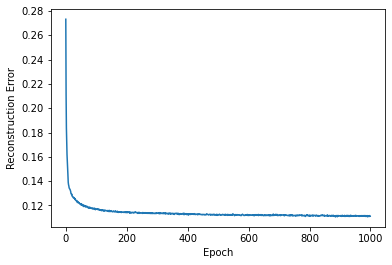

In [8]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");